# Collaboration and Competition

---

In this notebook, we implement Deep Deterministic Policy Gradient Reinforcement learning algorithm to solve Unity's [Tennis](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md#tennis) environment which is part of the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [ ]:
!pip -q install ./python

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
print('The state for the second agent looks like:', states[1])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]
The state for the second agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.4669857  -1.5
  0.          0.         -6.83172083  6.          0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.10000000149011612
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.0


When finished, you can close the environment.

In [6]:
# env.close()

### 4. Training the Agent

In this section we will use the DDPG algorithm to train our own Actor Critic Model to solve this environment.

When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [7]:
from ddpg_agent import Agent
from collections import deque
import torch

In [8]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=10, lr_actor=1e-4, lr_critic=5e-3)

In [9]:
def ddpg(n_episodes=4000, max_t=1000, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agent.reset()
        score = np.zeros(num_agents)
        while True:
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            score += rewards
            if np.any(dones):
                break 
        

        scores_deque.append(np.max(score))
        scores.append(np.max(score))
        if np.mean(scores_deque) >= 0.5 and np.max(scores_deque) > 2.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage100 Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break

        print('\rEpisode {}\tMaximum Score: {:.4f}\tAverage Score: {:.2f}\tEpsilon: {:.4f}\tNoise: {}'.format(i_episode, np.max(scores_deque), np.mean(scores_deque), agent.epsilon, agent.noise.value), end="")
        if i_episode % print_every == 0:
            print('\rEpisode {}\tMaximum Score: {:.4f}\tAverage Score: {:.2f}\tEpsilon: {:.4f}\tNoise: {}'.format(i_episode, np.max(scores_deque), np.mean(scores_deque), agent.epsilon, agent.noise.value))
            
    return scores

### Train the Agent (Optional)

**Note:** You can skip the remaining section and run the next section to load the pre-trained weights.

In [10]:
scores = ddpg()

Episode 100	Maximum Score: 0.1000	Average Score: 0.01	Epsilon: 0.9766	Noise: [-0.79682696  0.12074057]
Episode 200	Maximum Score: 0.1000	Average Score: 0.01	Epsilon: 0.9507	Noise: [-0.77364561 -0.67907475]
Episode 300	Maximum Score: 0.0000	Average Score: 0.00	Epsilon: 0.9284	Noise: [-0.47554733  0.7335882 ]
Episode 400	Maximum Score: 0.1000	Average Score: 0.01	Epsilon: 0.9025	Noise: [-0.5578739   0.45454558]
Episode 500	Maximum Score: 0.1000	Average Score: 0.00	Epsilon: 0.8804	Noise: [1.75039584 1.37479826]1]
Episode 600	Maximum Score: 0.5000	Average Score: 0.06	Epsilon: 0.8374	Noise: [-0.00724235 -0.34106654]
Episode 700	Maximum Score: 0.6000	Average Score: 0.10	Epsilon: 0.7775	Noise: [ 1.83889548 -1.36286567]
Episode 800	Maximum Score: 0.7000	Average Score: 0.11	Epsilon: 0.7161	Noise: [0.56143903 1.13743437] ]
Episode 900	Maximum Score: 0.6000	Average Score: 0.17	Epsilon: 0.6313	Noise: [1.19106796 1.02158562]6]
Episode 1000	Maximum Score: 2.6000	Average Score: 0.48	Epsilon: 0.4523	No

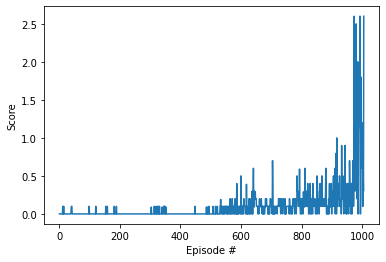

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Watching the Trained Agent

Execute the next code cells to load the saved Model and watch the solved environment.

In [ ]:
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.actor_local.eval()

agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))
agent.critic_local.eval()

In [13]:
for i in range(1, 6):
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = agent.act(states) # select an action (for each agent)
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.245000003837049
Total score (averaged over agents) this episode: 0.44500000681728125
Total score (averaged over agents) this episode: 0.6450000097975135
Total score (averaged over agents) this episode: 2.600000038743019
Total score (averaged over agents) this episode: 1.4450000217184424


When finished, you can close the environment.

In [ ]:
env.close()